In [8]:
import sys
sys.path.append('..')
import glob
import os

In [9]:
import importlib
import src.data_loader
import src.baselines
import pytorch_forecasting
import model.multimix_lstm
importlib.reload(src.data_loader)
importlib.reload(src.baselines)
importlib.reload(model.multimix_lstm)

<module 'model.multimix_lstm' from 'c:\\Users\\u0143591\\Documents\\Code\\process_tft\\notebooks\\..\\model\\multimix_lstm.py'>

In [10]:
from src.data_loader import DataLoader
from src.baselines import ModelComparisonExperiment as MCE
from src.data_loader import TimeSeriesDataLoader as TSDL
from model.multimix_lstm import LSTMModel

import numpy as np
import pandas as pd
import wandb
from pytorch_forecasting.data.encoders import NaNLabelEncoder, MultiNormalizer, TorchNormalizer, GroupNormalizer
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt

In [11]:
dl = DataLoader("../data/raw/")

In [12]:
# set seed
rng = np.random.default_rng(96)
pl.seed_everything(96)

Global seed set to 96


96

In [13]:
all_batches = []
for i in glob.glob("../data/raw/sensor_data_second_JSR/*.csv"):
    all_batches.append(os.path.basename(i).split()[2].split(".")[0])
batch_subset = rng.choice(all_batches, 50, replace=False)

In [14]:
dl = DataLoader("../data/raw/")
sensor_data = dl.load_sensors("sensor_data_second_JSR/*.csv", subset=None, per_minute=True)
event_data = dl.load_events("Event log.csv")

In [15]:
events_clean = dl.filter_events(event_data.reset_index(), "Pump start", "batch_id")
events_clean_in_cycle = events_clean[events_clean["status"] == "in_cycle"]
events_clean_in_cycle = dl.merge_event_min_to_list(events_clean_in_cycle)
#events_clean_in_cycle = dd.from_pandas(events_clean_in_cycle, npartitions=1)
events_clean_in_cycle.set_index(["batch_id", "timestamp"], inplace=True)

c:\Users\u0143591\Documents\Code\process_tft\notebooks\..\src\data_loader.py:223: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df["status"] = df.groupby(group_column)["concept:name"].apply(


In [16]:
events_clean_in_cycle["concept:name"] = events_clean_in_cycle["concept:name"].astype(str)

In [23]:
merged_data = dl.merge_sensors_and_events(sensor_data, events_clean_in_cycle)

In [18]:
target_map = {0: "other", -1: "censored event", 1: "pump adjustment"}
def get_events_target(df):
    df["target"] = 0
    df["target"] = df["target"] - df["concept:name"].isna().astype(int) + df["concept:name"].fillna("other").str.contains("Pump adjustment").astype(int)
    #df["target"].replace(target_map, inplace=true)
    return df
get_events_target(merged_data)
merged_data["concept:name"].fillna("censored event", inplace=True)#[]get_events_target(merged_data)

In [19]:
merged_data["target"].value_counts()

-1    1380862
 0       3881
 1        381
Name: target, dtype: int64

# ML Baselines

In [14]:
lagged_df = dl.add_lags(merged_data, group_col="batch_id", lag_columns=list(sensor_data.columns)[:-1], num_lags=10)

Adding lag 1 for column Filter 1 DeltaP
Adding lag 2 for column Filter 1 DeltaP
Adding lag 3 for column Filter 1 DeltaP
Adding lag 4 for column Filter 1 DeltaP
Adding lag 5 for column Filter 1 DeltaP
Adding lag 6 for column Filter 1 DeltaP
Adding lag 7 for column Filter 1 DeltaP
Adding lag 8 for column Filter 1 DeltaP
Adding lag 9 for column Filter 1 DeltaP
Adding lag 10 for column Filter 1 DeltaP
Adding lag 1 for column Filter 1 Inlet Pressure
Adding lag 2 for column Filter 1 Inlet Pressure
Adding lag 3 for column Filter 1 Inlet Pressure
Adding lag 4 for column Filter 1 Inlet Pressure
Adding lag 5 for column Filter 1 Inlet Pressure
Adding lag 6 for column Filter 1 Inlet Pressure
Adding lag 7 for column Filter 1 Inlet Pressure
Adding lag 8 for column Filter 1 Inlet Pressure
Adding lag 9 for column Filter 1 Inlet Pressure
Adding lag 10 for column Filter 1 Inlet Pressure
Adding lag 1 for column Filter 2 DeltaP
Adding lag 2 for column Filter 2 DeltaP
Adding lag 3 for column Filter 2 Delta

In [15]:
lagged_df = lagged_df.dropna(subset=["concept:name"]).reset_index()

In [16]:
input_cols = [i for i in lagged_df.columns if "lag" in i]
X = lagged_df[input_cols]
y = lagged_df["concept:name"].replace({i:"other" for i in lagged_df["concept:name"].unique() if i != "Pump adjustment"})

In [17]:
test_batch = rng.choice(batch_subset, 10)
train_mask = [i not in test_batch for i in lagged_df["batch_id"]]
test_mask = [i in test_batch for i in lagged_df["batch_id"]]
X_train = X[train_mask]
X_test = X[test_mask]
y_train = y[train_mask]
y_test = y[test_mask]

In [18]:
y_train_val = y_train.value_counts()
print("train: \n ---------- \n", y_train_val)
print("ratio: ", np.round(y_train_val["Pump adjustment"] / y_train_val["other"], 2))

y_test_val = y_test.value_counts()
print("test: \n ---------- \n", y_test_val)
print("ratio: ", np.round(y_test_val["Pump adjustment"] / y_test_val["other"], 2))

train: 
 ---------- 
 other              1448
Pump adjustment     116
Name: concept:name, dtype: int64
ratio:  0.08
test: 
 ---------- 
 other              292
Pump adjustment     40
Name: concept:name, dtype: int64
ratio:  0.14


In [19]:
baselines = MCE(X_train, X_test, y_train, y_test, groups=lagged_df["batch_id"][train_mask])

In [20]:
dt = baselines.train_decision_tree()

Fitting 5 folds for each of 70 candidates, totalling 350 fits
[CV] END ...................max_depth=2, min_samples_split=2; total time=   0.0s
[CV] END ...................max_depth=2, min_samples_split=2; total time=   0.0s
[CV] END ...................max_depth=2, min_samples_split=2; total time=   0.0s
[CV] END ...................max_depth=2, min_samples_split=2; total time=   0.0s
[CV] END ...................max_depth=2, min_samples_split=2; total time=   0.0s
[CV] END ...................max_depth=2, min_samples_split=4; total time=   0.0s
[CV] END ...................max_depth=2, min_samples_split=4; total time=   0.0s
[CV] END ...................max_depth=2, min_samples_split=4; total time=   0.0s
[CV] END ...................max_depth=2, min_samples_split=4; total time=   0.0s
[CV] END ...................max_depth=2, min_samples_split=4; total time=   0.0s
[CV] END ...................max_depth=2, min_samples_split=6; total time=   0.0s
[CV] END ...................max_depth=2, min_sa

In [21]:
print("Best model: \n",baselines.models["decision_tree"])
baselines.evaluate_model(dt)

Best model: 
 DecisionTreeClassifier(max_depth=15, min_samples_split=20)


{'accuracy': 0.8283132530120482,
 'f1': 0.0,
 'roc_auc': 0.4708904109589041,
 'specificity': 0.9417808219178082,
 'sensitivity': 0.0,
 'confusion_matrix': array([[275,  17],
        [ 40,   0]], dtype=int64)}

In [51]:
rf = baselines.train_random_forest()

Fitting 5 folds for each of 500 candidates, totalling 2500 fits
[CV] END ..max_depth=2, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END ..max_depth=2, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END ..max_depth=2, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END ..max_depth=2, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END ..max_depth=2, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END ..max_depth=2, min_samples_split=2, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=2, min_samples_split=2, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=2, min_samples_split=2, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=2, min_samples_split=2, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=2, min_samples_split=2, n_estimators=20; total time=   0.0s
[CV] END ..max_depth=2, min_samples_split=2, n_estimators=30; total time=   0.0s
[CV] END ..max_depth=2, min_samples_split=2, 

In [53]:
print("Best model: \n", baselines.models["random_forest"])
baselines.evaluate_model(rf)

Best model: 
 RandomForestClassifier(max_depth=20, min_samples_split=8, n_estimators=10)


{'accuracy': 0.858433734939759,
 'f1': 0.0,
 'roc_auc': 0.488013698630137,
 'specificity': 0.976027397260274,
 'sensitivity': 0.0,
 'confusion_matrix': array([[285,   7],
        [ 40,   0]], dtype=int64)}

# MultiMix

In [20]:
merged_data["pump_adjustment"] = merged_data["concept:name"].str.contains("Pump adjustment").astype(int)
merged_data["adjustment_in_next_5min"] = merged_data["pump_adjustment"].rolling(5, min_periods=1).max().shift(-(5)-1).fillna(0).astype(int)

In [21]:
merged_data["adjustment_in_next_5min"].value_counts()

0    1383556
1       1568
Name: adjustment_in_next_5min, dtype: int64

In [22]:
merged_data.to_parquet("merged_data.parquet", index=True)

Filter 1 DeltaP  Filter 1 Inlet Pressure  \
batch_id  timestamp                                                       
20K12001E 2020-10-14 13:15:00        -0.001055                 2.619439   
          2020-10-14 13:16:00        -0.000921                 2.619015   
          2020-10-14 13:17:00         0.001400                 2.618180   
          2020-10-14 13:18:00         0.000313                 2.617346   
          2020-10-14 13:19:00        -0.000773                 2.616512   
...                                        ...                      ...   
22B28001E 2022-03-08 20:17:00        -0.000716                 0.004681   
          2022-03-08 20:18:00        -0.000771                 0.004690   
          2022-03-08 20:19:00        -0.000359                 0.004699   
          2022-03-08 20:20:00        -0.000596                 0.004708   
          2022-03-08 20:21:00        -0.000932                 0.004715   

                               Filter 2 DeltaP  Pump Circulation Flow  \
batch_id  timestamp                                                     
20K12001E 2020-10-14 13:15:00         2.619480              25.276939   
          2020-10-14 13:16:00         2.619136              25.197757   
          2020-10-14 13:17:00         2.618457              24.677716   
          2020-10-14 13:18:00         2.617779              25.248260   
          2020-10-14 13:19:00         2.617101              25.721944   
...                                        ...                    ...   
22B28001E 2022-03-08 20:17:00        -0.001071               0.000000   
          2022-03-08 20:18:00        -0.001041               0.000000   
          2022-03-08 20:19:00        -0.001097               0.000000   
          2022-03-08 20:20:00        -0.001057               0.000000   
          2022-03-08 20:21:00        -0.001068               0.000000   

                               Tank Pressure  time_idx    concept:name  \
batch_id  timestamp                                                      
20K12001E 2020-10-14 13:15:00      -0.493176         0  censored event   
          2020-10-14 13:16:00      -0.483144         1  censored event   
          2020-10-14 13:17:00      -0.464754         2  censored event   
          2020-10-14 13:18:00      -0.597642         3  censored event   
          2020-10-14 13:19:00      -0.569582         4  censored event   
...                                      ...       ...             ...   
22B28001E 2022-03-08 20:17:00       0.046534      7908  censored event   
          2022-03-08 20:18:00       0.046723      7909  censored event   
          2022-03-08 20:19:00       0.046911      7910  censored event   
          2022-03-08 20:20:00       0.047100      7911  censored event   
          2022-03-08 20:21:00       0.047230      7912  censored event   

                               target  pump_adjustment  \
batch_id  timestamp                                      
20K12001E 2020-10-14 13:15:00      -1                0   
          2020-10-14 13:16:00      -1                0   
          2020-10-14 13:17:00      -1                0   
          2020-10-14 13:18:00      -1                0   
          2020-10-14 13:19:00      -1                0   
...                               ...              ...   
22B28001E 2022-03-08 20:17:00      -1                0   
          2022-03-08 20:18:00      -1                0   
          2022-03-08 20:19:00      -1                0   
          2022-03-08 20:20:00      -1                0   
          2022-03-08 20:21:00      -1                0   

                               adjustment_in_next_5min  
batch_id  timestamp                                     
20K12001E 2020-10-14 13:15:00                        0  
          2020-10-14 13:16:00                        0  
          2020-10-14 13:17:00                        0  
          2020-10-14 13:18:00                        0  
          2020-10-14 13:19:00                

In [138]:
def extract_event_windows(df, event="pump_adjustment", plot=False):
    event_windows = []
    pump_circ = []
    
    # Process each batch separately
    for batch_id, group in df.groupby('batch_id'):
        event_times = group.loc[group[event] == 1, 'timestamp']

        for event_time in event_times:
            start_time = event_time - pd.Timedelta(minutes=10)
            end_time = event_time + pd.Timedelta(minutes=10)
            
            window = group[(group['timestamp'] >= start_time) & (group['timestamp'] <= end_time)]
            
            event_windows.append(window)
            pump_circ.append(window["Pump Circulation Flow"].values)
            if plot:
                plt.plot(range(len(window)), window["Pump Circulation Flow"])
    plt.plot(np.array(pump_circ).mean(axis=0))
    plt.axvline(10, c="red")
    plt.text(11, 1000, "Pump adjustment", c="red")
    plt.ylabel("Pump Circulation Flow")
    plt.xlabel("Absolute Time (in minutes)")
    plt.xticks(ticks=np.arange(0,21), labels=np.arange(-10,11,1))
    plt.show()
            
    return np.array(pump_circ) #pd.concat(event_windows)

In [139]:
merged_data = merged_data.dropna(subset=["Pump Circulation Flow"])

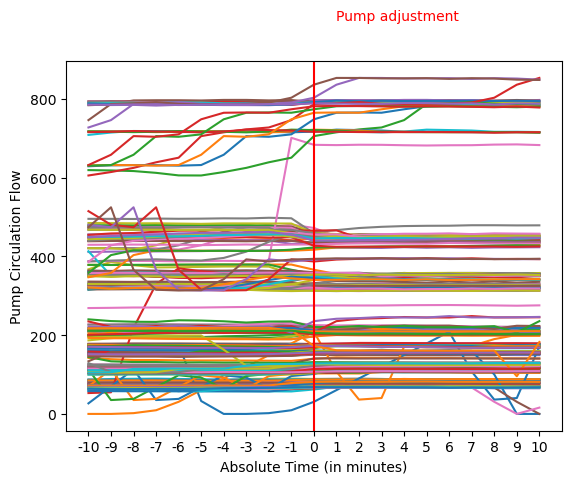

In [140]:
k = extract_event_windows(merged_data.reset_index(), plot=True)

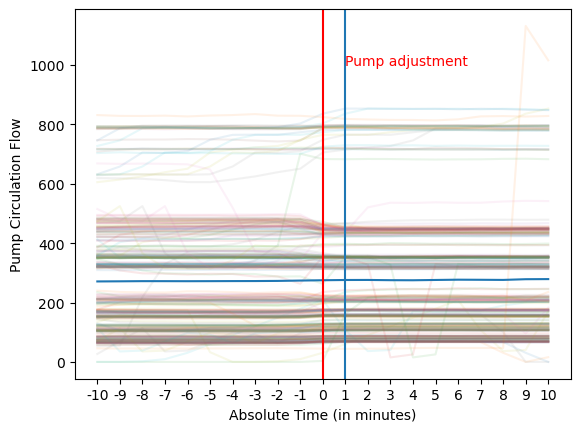

In [77]:
k = extract_event_windows(merged_data.reset_index(), plot=True)


([<matplotlib.axis.XTick at 0x1d8beaa4c40>,
 [Text(1, 0, '-10'),
  Text(2, 0, '-9'),
  Text(3, 0, '-8'),
  Text(4, 0, '-7'),
  Text(5, 0, '-6'),
  Text(6, 0, '-5'),
  Text(7, 0, '-4'),
  Text(8, 0, '-3'),
  Text(9, 0, '-2'),
  Text(10, 0, '-1'),
  Text(11, 0, '0'),
  Text(12, 0, '1'),
  Text(13, 0, '2'),
  Text(14, 0, '3'),
  Text(15, 0, '4'),
  Text(16, 0, '5'),
  Text(17, 0, '6'),
  Text(18, 0, '7'),
  Text(19, 0, '8'),
  Text(20, 0, '9'),
  Text(21, 0, '10')])

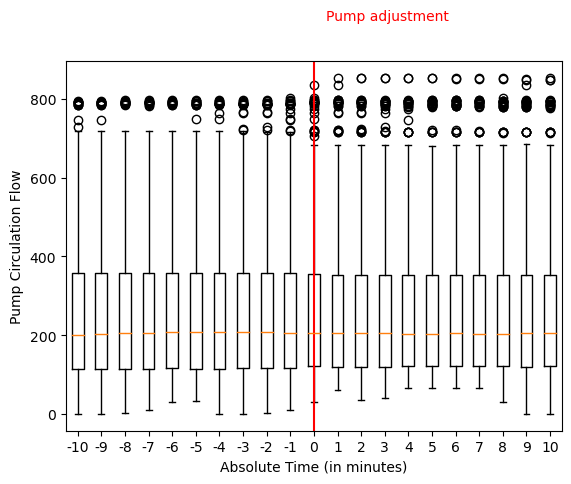

In [141]:
plt.boxplot(k)
plt.axvline(11, c="red")
plt.text(11.5, 1000, "Pump adjustment", c="red")
plt.ylabel("Pump Circulation Flow")
plt.xlabel("Absolute Time (in minutes)")
plt.xticks(ticks=np.arange(1,22), labels=np.arange(-10,11,1))
#plt.yscale('log')

Text(0, 0.5, 'Pump Circulation Flow')

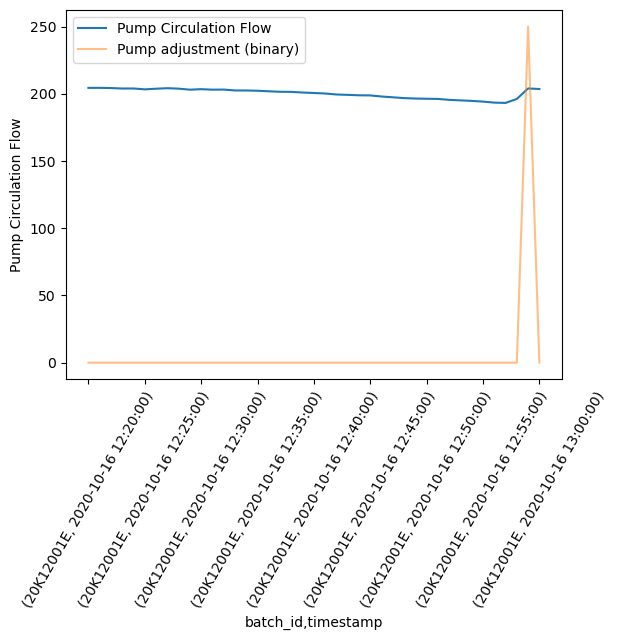

In [108]:
idx = pd.IndexSlice
sub_batch = merged_data.loc[idx["20K12001E", "2020-10-16 12:20":"2020-10-16 13:00"], :]
sub_batch["Pump Circulation Flow"].plot(label="Pump Circulation Flow")
(sub_batch["pump_adjustment"] * 250).plot(alpha=0.5, label="Pump adjustment (binary)")
plt.xticks(rotation=60)
plt.legend()
plt.ylabel("Pump Circulation Flow")

Text(0.5, 1.0, 'Total number of pump adjustments per batch')

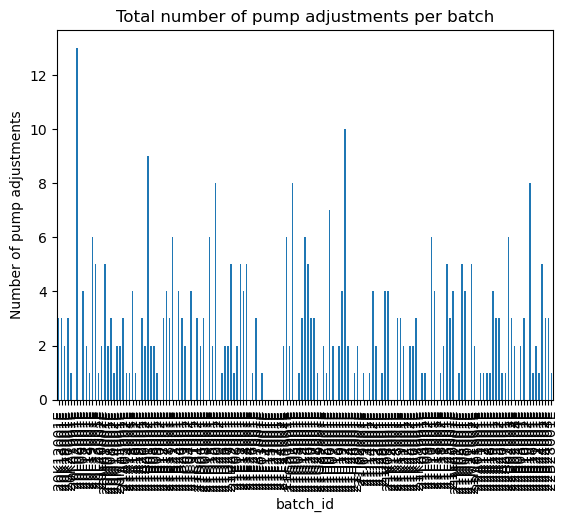

In [91]:
merged_data.reset_index().groupby("batch_id")["pump_adjustment"].sum().plot(kind="bar")
plt.ylabel("Number of pump adjustments")
plt.title("Total number of pump adjustments per batch")

- Add cumulative count of number of pump adjustment until T
# NORMALIZE BY GROUP!!!

In [131]:
more_than_two = merged_data.reset_index().groupby("batch_id")["pump_adjustment"].sum() > 2
more_than_two = more_than_two[more_than_two].index
merged_data = merged_data[merged_data.reset_index()["batch_id"].isin(more_than_two).values]

In [7]:
merged_data.isna().sum()

NameError: name 'merged_data' is not defined

In [134]:
merged_data.dropna(subset=["Filter 1 DeltaP"], inplace=True)
merged_data["Pump Circulation Flow"] = merged_data.reset_index().groupby("batch_id")["Pump Circulation Flow"].fillna(method="ffill").values
merged_data.dropna(subset=["Pump Circulation Flow"], inplace=True)
merged_data.isna().sum()

C:\Users\u0143591\AppData\Local\Temp\ipykernel_30136\3163902875.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_data.dropna(subset=["Filter 1 DeltaP"], inplace=True)
C:\Users\u0143591\AppData\Local\Temp\ipykernel_30136\3163902875.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_data["Pump Circulation Flow"] = merged_data.reset_index().groupby("batch_id")["Pump Circulation Flow"].fillna(method="ffill").values
C:\Users\u0143591\AppData\Local\Temp\ipykernel_30136\3163902875.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

Filter 1 DeltaP            0
Filter 1 Inlet Pressure    0
Filter 2 DeltaP            0
Pump Circulation Flow      0
Tank Pressure              0
time_idx                   0
concept:name               0
target                     0
pump_adjustment            0
adjustment_in_next_5min    0
dtype: int64

* Is it missing between start and stop? Yes
* Pump Circulation Flow can be ffilled with last known value
* Can we use an extending window instead of a fixed length window? 

In [143]:
multimix_input = merged_data.reset_index().loc[:,:]
batch = rng.choice(multimix_input, 30)
val_batch = batch[:15]
test_batch = batch[15:]
train_mask = [i not in batch for i in multimix_input["batch_id"]]
val_mask = [i in val_batch for i in multimix_input["batch_id"]]
test_mask = [i in test_batch for i in multimix_input["batch_id"]]
multimix_train = multimix_input[train_mask].copy()
multimix_val = multimix_input[val_mask].copy()
multimix_test = multimix_input[test_mask].copy()

cols_to_scale = [i for i in multimix_train.columns if "Filter" in i] + ["Tank Pressure", "Pump Circulation Flow"]
#ss = StandardScaler()
#multimix_train[cols_to_scale] = ss.fit_transform(multimix_train[cols_to_scale])
#multimix_val[cols_to_scale] = ss.transform(multimix_val[cols_to_scale])
#multimix_test[cols_to_scale] = ss.transform(multimix_test[cols_to_scale])

In [150]:
len(multimix_train) / multimix_train["adjustment_in_next_5min"].sum()

451.47407407407405

In [591]:
cat_encoders = {
    '__group_id__batch_id': NaNLabelEncoder(add_nan=True, warn=True),
    'batch_id': NaNLabelEncoder(add_nan=True, warn=True),
    'concept:name': NaNLabelEncoder(add_nan=True, warn=True)
    }

multimix_data = TSDL(
    data=multimix_train,
    time_idx="time_idx",
    target_cols="adjustment_in_next_5min", #"Pump Circulation Flow"],
    group_cols=["batch_id"],
    time_varying_unknown_reals=[
        "Filter 1 DeltaP",
        "Filter 1 Inlet Pressure",
        "Filter 2 DeltaP",
        "Tank Pressure",
        "Pump Circulation Flow"
    ],
    allow_missing_timesteps=True,
    add_relative_time_idx=False,
    add_target_scales=True,
    time_varying_unknown_categoricals=["concept:name"],
    min_encoder_length=120,
    max_encoder_length=120,
    min_prediction_length=1,
    max_prediction_length=1,
    target_normalizer=TorchNormalizer(method="identity"),#MultiNormalizer([TorchNormalizer(method="identity"), GroupNormalizer(groups=["batch_id"], scale_by_group=True)]),
    scalers={i: GroupNormalizer(groups=["batch_id"], scale_by_group=True) for i in [k for k in cols_to_scale]}, #if k != "Pump Circulation Flow"]},
    categorical_encoders=cat_encoders,
)

# Adapt to include 5 min for pump circ, and 1 min for binary task.

In [592]:
# convert the dataset to a dataloader
train_dataloader = multimix_data.train_data.to_dataloader(batch_size=64, train=True, shuffle=True)

val_dataloader = multimix_data.get_validation_data(multimix_val, batch_size=64)
test_dataloader = multimix_data.get_test_data(multimix_test, batch_size=64)

c:\Users\u0143591\Anaconda3\envs\multimix_process\lib\site-packages\pytorch_forecasting\data\encoders.py:318: UserWarning: Found 2 unknown classes which were set to NaN
  warnings.warn(
c:\Users\u0143591\Anaconda3\envs\multimix_process\lib\site-packages\pytorch_forecasting\data\encoders.py:318: UserWarning: Found 2 unknown classes which were set to NaN
  warnings.warn(


In [25]:
# make sure to change the labels to a binary problem of the target!!

In [607]:
model = LSTMModel(
    input_size=len(multimix_data.train_data.reals),
    hidden_size=64,
    num_layers=2,
    output_size=[1],
    targets=["pump_adjustment"],#, "Pump Circulation Flow"],
    num_categories=len(multimix_data.train_data.get_parameters()["categorical_encoders"]["concept:name"].classes_),
    task_weights=[1, 1],
    mixed_task_name="pump_adjustment",
    censored_task_label=-1,
    dropout_rate=0.3,
    pos_weight=450,
)

In [596]:
wandb.init(project="multimix_lstm", entity="bdeforce")

In [597]:
logger = WandbLogger(project="multimix_lstm")
model_checkpoint = pl.callbacks.ModelCheckpoint(
    monitor="val_loss_mixed",
    dirpath="checkpoints_classification/",
    filename="multimix_lstm-{epoch}-{val_loss:.3f}",
    save_top_k=1,
    save_last=True,
    mode="min",
)

c:\Users\u0143591\Anaconda3\envs\multimix_process\lib\site-packages\pytorch_lightning\loggers\wandb.py:395: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


In [608]:
trainer = pl.Trainer(
    logger=logger, 
    max_epochs=50, 
    limit_train_batches=1., 
    check_val_every_n_epoch=1, 
    limit_val_batches=1., 
    num_sanity_val_steps=0,
    callbacks=[model_checkpoint],
    enable_progress_bar=True,
    )

trainer.fit(model, train_dataloader, val_dataloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..

  | Name      | Type      | Params
----------------------------------------
0 | embedding | Embedding | 1.7 K 
1 | lstm      | LSTM      | 68.4 K
2 | fc        | Linear    | 65    
----------------------------------------
70.1 K    Trainable params
0         Non-trainable params
70.1 K    Total params
0.280     Total estimated model params size (MB)
c:\Users\u0143591\Anaconda3\envs\multimix_process\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is t

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


In [609]:
trainer.checkpoint_callback.best_model_path

'C:\\Users\\u0143591\\Documents\\Code\\process_tft\\notebooks\\checkpoints_classification\\multimix_lstm-epoch=31-val_loss=0.000.ckpt'

In [611]:
model_ = LSTMModel.load_from_checkpoint(
    trainer.checkpoint_callback.best_model_path, 
    input_size=len(multimix_data.train_data.reals),
    hidden_size=64,
    num_layers=2,
    output_size=[1],
    targets="pump_adjustment",
    num_categories=len(multimix_data.train_data.get_parameters()["categorical_encoders"]["concept:name"].classes_),
    task_weights=1,
    mixed_task_name="pump_adjustment",
    censored_task_label=-1,
    dropout_rate=0.3,
    pos_weight=450,
    )

In [412]:
x, y = next(iter(_dataloader))

In [423]:
y

([tensor([[0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
        

In [445]:
x, y = next(iter(train_dataloader))
np.sum(y[0][0].numpy() > 0)

1

In [449]:
np.where(y[0][0].numpy() > 0)

(array([42], dtype=int64), array([0], dtype=int64))

In [458]:
df[((df["batch_id"] == batch_id) & (df["time_idx"].between(time_idx+1, time_idx+11)))]["pump_adjustment"].reset_index(drop=True)

0     0
1     0
2     0
3     0
4     0
5     1
6     0
7     0
8     0
9     0
10    0
Name: pump_adjustment, dtype: int32

In [467]:
np.where(adjustment==1)


(array([6], dtype=int64),)

In [473]:
y_hat_bin

tensor([ 1.3222, -1.6752,  1.9069,  0.2300,  1.9401,  0.8399,  1.0269,  1.4415,
        -3.2652, -1.7181,  0.7719,  1.7616, -2.2274,  0.6834,  0.7163,  1.4193,
         0.7465,  1.3901,  0.6282,  0.3185,  0.8280,  2.0715, -1.9977,  0.2800,
        -2.4321,  2.0305,  0.7659,  1.4417,  1.4370,  1.6651, -2.3174,  1.3879,
         1.8915,  0.6214, -1.5996,  0.9549,  1.0856,  1.3380,  0.3306,  1.8791,
         1.3392,  0.8051,  0.4803, -2.3191, -2.4310,  0.7503,  0.5969,  0.8241,
         0.9832,  0.2922,  0.9397,  0.1321, -1.7246,  0.2672, -1.7177,  0.8302,
         2.1049,  1.7152,  0.9346,  2.0467,  1.4566,  0.2129,  0.7963, -1.9301])

In [574]:
def compute_mape(dataloader, max_iterations):
    mape = []
    batches = []
    for i, batch in enumerate(dataloader):
        if i >= max_iterations:
            break
            
        x, y = batch 
        y_hat_bin = model_.eval()(x)[:,:,0].detach()
        y_hat_bin = torch.sigmoid(y_hat_bin) > 0.5
        y_hat_cont = model_.eval()(x)[:,:,1].detach()
        mape_error = np.abs(y[0][1].numpy() - y_hat_cont.numpy()) / (y[0][1].numpy()) * 100
        mape_error = np.nanmean(np.where(mape_error == np.inf, np.nan, mape_error))
        mape.append(mape_error)
        batches.append(batch)
    return batches, mape

def plot_results(x, example_idx, normalizer, target_history, target_future, y_hat_cont, adjustment, actual_surrounding_pred):
    plt.plot(x["encoder_cont"][example_idx,:,-1].numpy()* normalizer.numpy()[1] + normalizer.numpy()[0], c='blue', label="History")
    plt.scatter(range(120), target_history, c="blue", s=12)
    plt.scatter(range(123,134), target_future, c="red", s=12)
    plt.plot(range(123,134), target_future, c="red", label="Future (for context)")
    plt.scatter(120,x["decoder_target"][1][example_idx,:].numpy(), c="black", marker="x", label="True")
    plt.scatter(120, y_hat_cont[example_idx,:].numpy(), c="green", marker="x", label="Predicted")
    if adjustment.sum() > 0:
        idx = np.where(adjustment == 1)[0] + 120
        plt.axvline(idx, linestyle='--', c="black")
    plt.plot([119,120,123], actual_surrounding_pred, c="black", linestyle=":", alpha=0.4)
    plt.plot([119,120,123], [target_history.iloc[-1], y_hat_cont[example_idx,:].item(), target_future.iloc[0]], c="green", linestyle=":", alpha=0.4)
    plt.legend(loc="best")
    plt.show()

def plot_overview(merged_data, dataloader, model_, multimix_data, max_iterations=5):
    df = merged_data.reset_index()
    mape = []
    
    for i, batch in enumerate(dataloader):
        if i >= max_iterations:
            break
            
        x, y = batch 
        example_idx = np.random.randint(0,64)
        y_hat_bin = model_.eval()(x)[:,:,0][mask].detach()
        y_hat_bin = torch.sigmoid(y_hat_bin) > 0.5
        y_hat_cont = model_.eval()(x)[:,:,1].detach()
        time_idx, batch_id = multimix_data.train_data.x_to_index(x).iloc[example_idx].values
        normalizer = x["target_scale"][1][example_idx]
        target_history = df[((df["batch_id"] == batch_id) & (df["time_idx"].between(time_idx - 120, time_idx-1)))]["Pump Circulation Flow"]
        target_future = df[((df["batch_id"] == batch_id) & (df["time_idx"].between(time_idx+1, time_idx+11)))]["Pump Circulation Flow"]
        adjustment = df[((df["batch_id"] == batch_id) & (df["time_idx"].between(time_idx, time_idx+6)))]["pump_adjustment"].reset_index(drop=True)
        actual_surrounding_pred = df[((df["batch_id"] == batch_id) & (df["time_idx"].between(time_idx-1, time_idx+1)))]["Pump Circulation Flow"]

        #mape_error = compute_mape(target_future, y_hat_cont, example_idx)
        #mape.append(mape_error)
        print(y_hat_bin[example_idx])

        plot_results(x, example_idx, normalizer, target_history, target_future, y_hat_cont, adjustment, actual_surrounding_pred)

    return mape


In [584]:
batches, mape = compute_mape(val_dataloader, max_iterations=5)

C:\Users\u0143591\AppData\Local\Temp\ipykernel_30136\2315152235.py:12: RuntimeWarning: divide by zero encountered in divide
  mape_error = np.abs(y[0][1].numpy() - y_hat_cont.numpy()) / (y[0][1].numpy()) * 100
C:\Users\u0143591\AppData\Local\Temp\ipykernel_30136\2315152235.py:13: RuntimeWarning: Mean of empty slice
  mape_error = np.nanmean(np.where(mape_error == np.inf, np.nan, mape_error))


In [586]:
np.nanmean(mape)

21.930094

tensor(True)


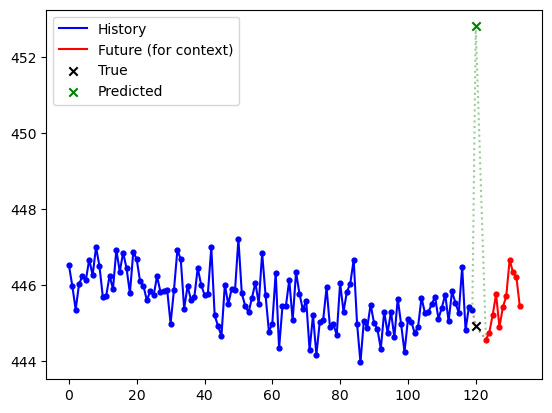

tensor(False)


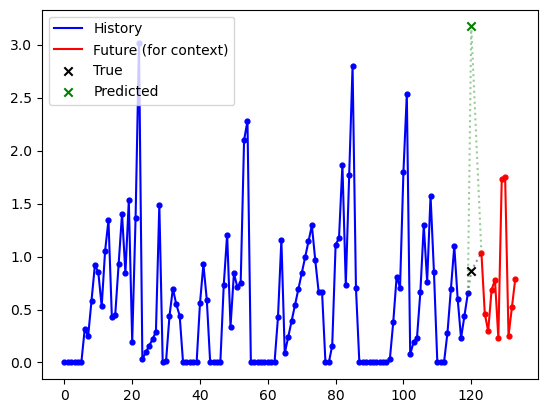

tensor(True)


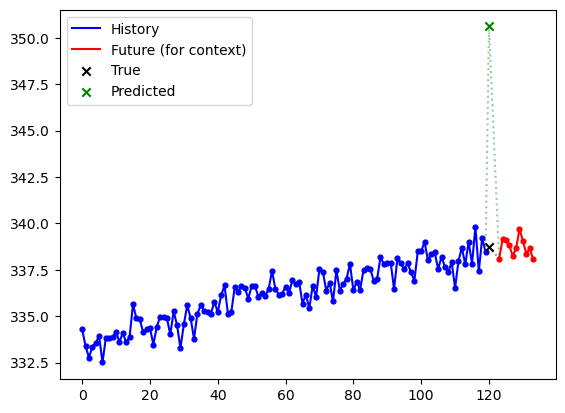

tensor(True)


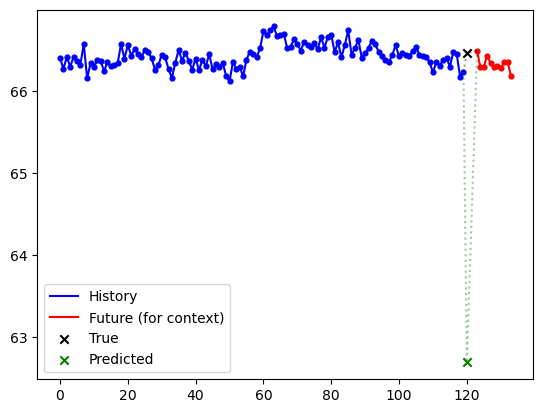

tensor(True)


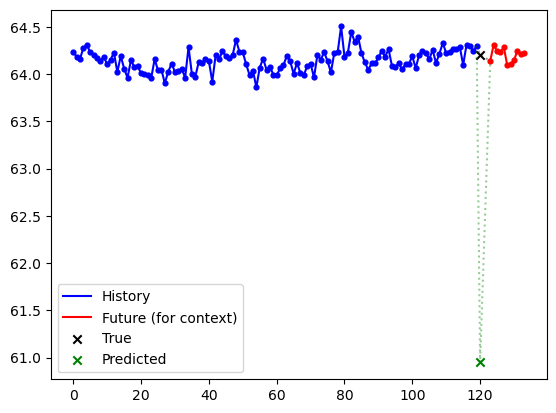

[]

In [570]:
plot_overview(merged_data, batches, model_, multimix_data, max_iterations=5)

tensor(True)


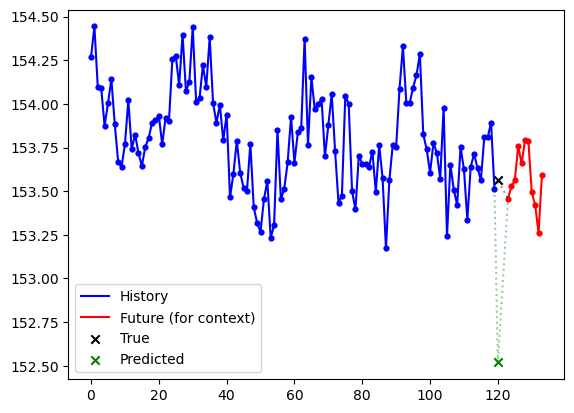

tensor(False)


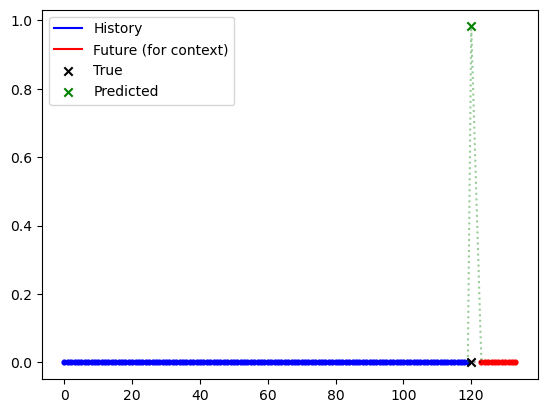

tensor(True)


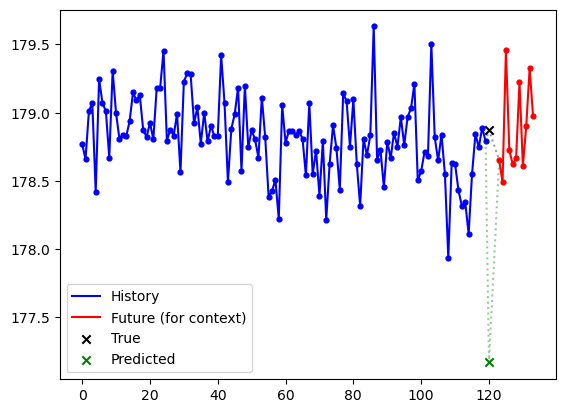

tensor(True)


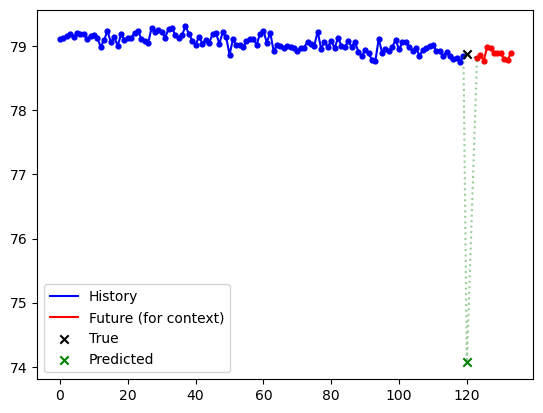

tensor(True)


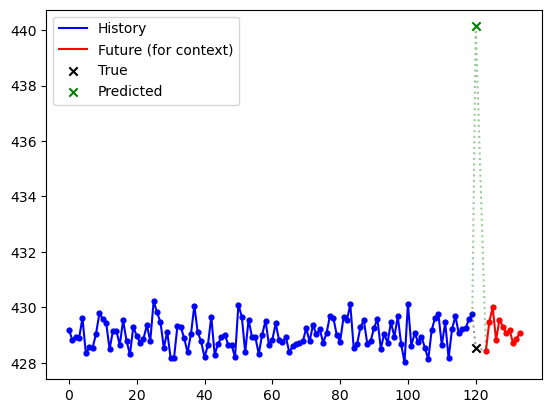

In [524]:
df = merged_data.reset_index()
max_iterations = 5
mape = []
for i, batch in enumerate(train_dataloader):
    if i >= max_iterations:
        break
    else:
        x, y = batch 
        example_idx = np.random.randint(0,64)

        y_hat_bin = model_.eval()(x)[:,:,0][mask].detach()
        y_hat_bin = torch.sigmoid(y_hat_bin) > 0.5
        y_hat_cont = model_.eval()(x)[:,:,1].detach()
        time_idx, batch_id = multimix_data.train_data.x_to_index(x).iloc[example_idx].values
        normalizer = x["target_scale"][1][example_idx]
        target_history = df[((df["batch_id"] == batch_id) & (df["time_idx"].between(time_idx - 120, time_idx-1)))]["Pump Circulation Flow"] 
        #target_history = (target_history - normalizer.numpy()[0]) / normalizer.numpy()[1]
        target_future = df[((df["batch_id"] == batch_id) & (df["time_idx"].between(time_idx+1, time_idx+11)))]["Pump Circulation Flow"]
        adjustment = df[((df["batch_id"] == batch_id) & (df["time_idx"].between(time_idx, time_idx+6)))]["pump_adjustment"].reset_index(drop=True)
        actual_surrounding_pred = df[((df["batch_id"] == batch_id) & (df["time_idx"].between(time_idx-1, time_idx+1)))]["Pump Circulation Flow"]
        # target_future = (target_future - normalizer.numpy()[0]) / normalizer.numpy()[1]
        #target_history = (target_history - normalizer.get_parameters(groups=batch_id)[0]) / normalizer.get_parameters(groups=batch_id)[1]

        mape.append(np.abs())

        # history
        plt.plot(x["encoder_cont"][example_idx,:,-1].numpy()* normalizer.numpy()[1] + normalizer.numpy()[0], c='blue', label="History")
        plt.scatter(range(120), target_history, c="blue", s=12)

        # future
        plt.scatter(range(123,134), target_future, c="red", s=12)
        plt.plot(range(123,134), target_future, c="red", label="Future (for context)")

        # prediction
        plt.scatter(120,x["decoder_target"][1][example_idx,:].numpy(), c="black", marker="x", label="True")# * normalizer.numpy()[1] + normalizer.numpy()[0])
        plt.scatter(120, y_hat_cont[example_idx,:].numpy(), c="green", marker="x", label="Predicted")
        if adjustment.sum() > 0:
            idx = np.where(adjustment == 1)[0] + 120
            plt.axvline(idx, linestyle='--', c="black")
        print(y_hat_bin[example_idx])

        # surroundings
        plt.plot([119,120,123], actual_surrounding_pred, c="black", linestyle=":", alpha=0.4)
        plt.plot([119,120,123], [target_history.iloc[-1], y_hat_cont[example_idx,:].item(), target_future.iloc[0]], c="green", linestyle=":", alpha=0.4)

        
        plt.legend(loc="best")
        plt.show()

In [386]:
[target_history.iloc[-1], y_hat_cont[example_idx,:].item(), target_future.iloc[0]]

[175.906611887614, 173.88990783691406, 175.54791895548504]

In [220]:
import torchmetrics
import torch
max_iterations = 5  # Or any number you decide

pred_df = []
for i, batch in enumerate(train_dataloader):
    if i >= max_iterations:
        break
    else:
        x, y = batch
        y_true = y[0][0]
        mask = y_true != -1
        y_true = y_true[mask]
        y_hat_bin = model_.eval()(x)[:,:,0][mask].detach()
        y_hat_cont = model_.eval()(x)[:,:,1].detach()
        y_hat_bin = torch.sigmoid(y_hat_bin) > 0.5
        groups = x["groups"].numpy().squeeze()
        print(y_hat_bin.to(torch.float64))
        print(y_true)
        print(torchmetrics.Recall(task="binary")(y_hat_bin, y_true))
        print("-----"*10)

tensor([1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0.,
        1., 1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 0., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=torch.float64)
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor(0.)
--------------------------------------------------
tensor([0., 0., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 0., 1., 1.,
        1., 1., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
        1., 0., 0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 1., 1., 1., 0., 1., 1.,
        0., 1., 1., 0., 1., 0., 0., 0., 1., 0.], dtype=torch.float64)
tensor([0., 0., 0., 0., 0., 0., 0., 0

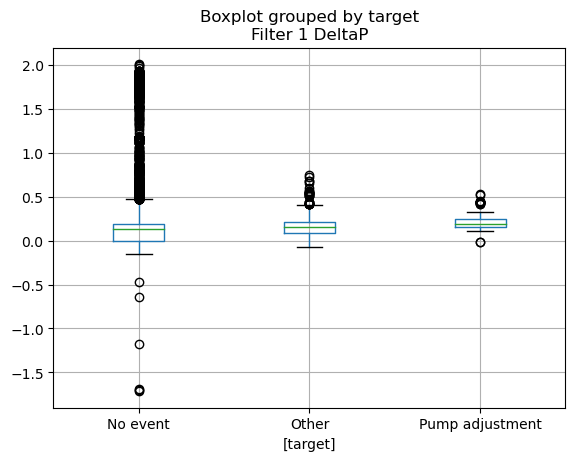

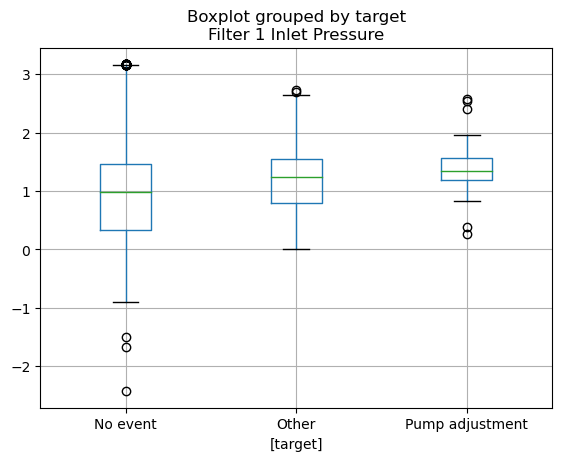

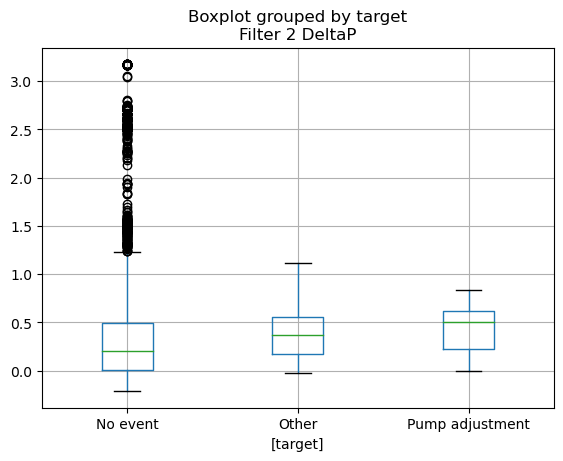

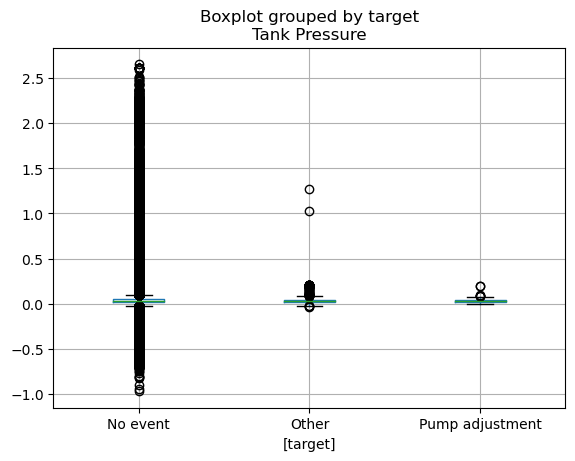

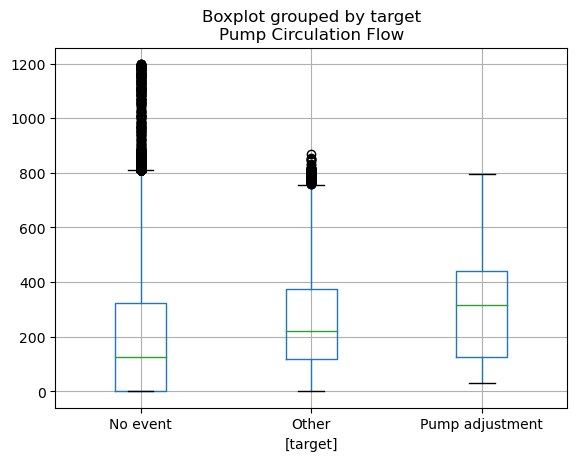

In [420]:
sub_merge = merged_data
#sub_merge["concept:name"] = sub_merge["concept:name"].replace({i:"other" for i in sub_merge["concept:name"].unique() if i != "Pump adjustment"})
temporal_data = ['Filter 1 DeltaP', 'Filter 1 Inlet Pressure', 'Filter 2 DeltaP','Tank Pressure', 'Pump Circulation Flow']
sub_merge["target"] = sub_merge["target"].replace({i:j for i,j in enumerate(le.classes_)})
for i in temporal_data:
    sub_merge[[i, "target"]].boxplot(by="target")
    #plt.show()
#merged_data[merged_data["concept:name"] == "Pump adjustment"]

In [26]:
merged_data.to_csv("merged_data.csv", index=False)

..\src\data_loader.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_group["time_diff"] = sub_group["time_diff"].dt.total_seconds() / 60


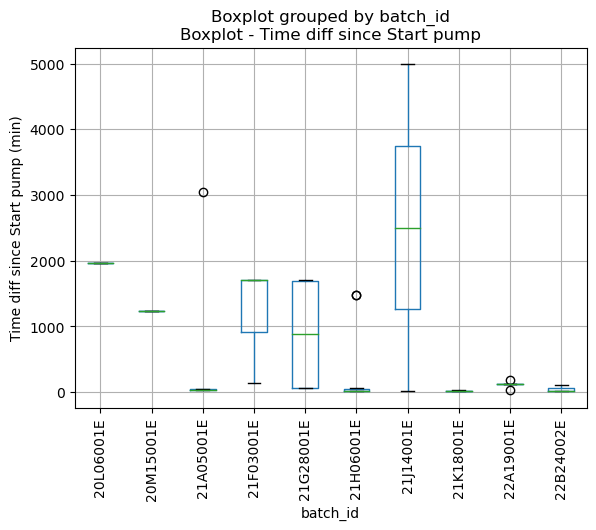

In [234]:
dl.plot_sample_timediff(events_clean_in_cycle.reset_index(), "time_diff", "Pump adjustment", "batch_id", sample_size=10)